# Imports here 👇

In [1]:
import numpy as np
from typing import Tuple
from google.cloud import storage
from keras import Model, Sequential, layers, regularizers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-03-07 11:37:41.635479: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 11:37:41.640318: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 11:37:41.678864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 11:37:41.678904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 11:37:41.681224: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
from ai_detector.params import *

# Loading the Data

### Fake data first 👇

In [3]:
 # get the data from GCS
storage_client = storage.Client()

In [4]:
# create train data
X = []
y = []
blob_fake = storage_client.list_blobs(BUCKET_NAME_FAKE,
                                        prefix="IF-CC1M",
                                        max_results=5)

In [5]:
for blob in blob_fake:
    bytes_out = blob.download_as_bytes()
    array_tensor = tf.convert_to_tensor(bytes_out)
    img_array = tf.io.decode_image(array_tensor)
    X.append(img_array)
    y.append(1)

X, y

2024-03-07 11:37:50.541910: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 11:37:50.542119: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


([<tf.Tensor: shape=(256, 256, 3), dtype=uint8, numpy=
  array([[[17, 17, 16],
          [21, 20, 22],
          [21, 23, 21],
          ...,
          [40, 37, 38],
          [34, 33, 33],
          [ 9,  6, 11]],
  
         [[14, 14, 14],
          [20, 18, 18],
          [22, 22, 22],
          ...,
          [37, 36, 38],
          [34, 32, 34],
          [ 8,  7, 10]],
  
         [[12, 11, 12],
          [24, 23, 24],
          [33, 32, 32],
          ...,
          [37, 37, 35],
          [33, 32, 32],
          [ 8,  7,  8]],
  
         ...,
  
         [[ 6,  3,  3],
          [34, 33, 33],
          [39, 36, 38],
          ...,
          [37, 35, 35],
          [36, 34, 37],
          [11,  9, 10]],
  
         [[ 0,  1,  3],
          [31, 31, 31],
          [39, 37, 38],
          ...,
          [36, 36, 37],
          [38, 35, 38],
          [11, 10, 10]],
  
         [[ 2,  3,  5],
          [35, 32, 34],
          [37, 37, 38],
          ...,
          [37, 37, 38],
  

In [6]:
len(X)

5

### Now for the real data 👇

In [7]:
blob_real = storage_client.list_blobs(BUCKET_NAME_REAL,
                                        prefix="extracted",
                                        max_results=5)
for blob in blob_real:
    bytes_out = blob.download_as_bytes()
    array_tensor = tf.convert_to_tensor(bytes_out)
    img_array = tf.io.decode_image(array_tensor)
    X.append(img_array)
    y.append(0)

X, y

([<tf.Tensor: shape=(256, 256, 3), dtype=uint8, numpy=
  array([[[17, 17, 16],
          [21, 20, 22],
          [21, 23, 21],
          ...,
          [40, 37, 38],
          [34, 33, 33],
          [ 9,  6, 11]],
  
         [[14, 14, 14],
          [20, 18, 18],
          [22, 22, 22],
          ...,
          [37, 36, 38],
          [34, 32, 34],
          [ 8,  7, 10]],
  
         [[12, 11, 12],
          [24, 23, 24],
          [33, 32, 32],
          ...,
          [37, 37, 35],
          [33, 32, 32],
          [ 8,  7,  8]],
  
         ...,
  
         [[ 6,  3,  3],
          [34, 33, 33],
          [39, 36, 38],
          ...,
          [37, 35, 35],
          [36, 34, 37],
          [11,  9, 10]],
  
         [[ 0,  1,  3],
          [31, 31, 31],
          [39, 37, 38],
          ...,
          [36, 36, 37],
          [38, 35, 38],
          [11, 10, 10]],
  
         [[ 2,  3,  5],
          [35, 32, 34],
          [37, 37, 38],
          ...,
          [37, 37, 38],
  

In [8]:
len(X)

10

In [9]:
len(y)

10

### We need to reshape the real data to fit with the fake one 😒

The **fake data** is comprized of images of `shape` (256,256) whereas the **real data** has images of `shape` (512, 512).

We need to `resize` the **real** images to (256,256) to avoid any comflicts between the data.

There is a function for this: `tf.image.resize` 🤩

#### Let's try this out with **one** image 👌

In [13]:
tf.image.resize(X[-1], [256,256])

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[ 53.5,  46.5,  53.5],
        [ 50. ,  43. ,  50. ],
        [ 49.5,  43.5,  47.5],
        ...,
        [ 37. ,  40. ,  45. ],
        [ 38.5,  39.5,  44.5],
        [ 38. ,  37. ,  42. ]],

       [[ 49.5,  47.5,  52.5],
        [ 46. ,  44. ,  49. ],
        [ 45. ,  43. ,  46. ],
        ...,
        [ 37.5,  40.5,  45.5],
        [ 38.5,  39.5,  43.5],
        [ 39.5,  38.5,  43.5]],

       [[ 46.5,  45.5,  50.5],
        [ 46. ,  45. ,  50. ],
        [ 46. ,  46. ,  48. ],
        ...,
        [ 36. ,  41. ,  46. ],
        [ 36.5,  40. ,  44. ],
        [ 38. ,  37. ,  42. ]],

       ...,

       [[188. , 152. , 154. ],
        [197. , 158. , 161. ],
        [195.5, 154.5, 156. ],
        ...,
        [ 38. ,  35. ,  42. ],
        [ 36.5,  33.5,  40.5],
        [ 35. ,  32. ,  41. ]],

       [[243.5, 246.5, 253.5],
        [245. , 244.5, 252.5],
        [240. , 235.5, 245. ],
        ...,
        [ 38. ,  32.5,

### Let's add our magic code to our loading functions 🙌

In [26]:
X = []
y = []
blob_fake = storage_client.list_blobs(BUCKET_NAME_FAKE,
                                        prefix="IF-CC1M",
                                        max_results=5)
for blob in blob_fake:
    bytes_out = blob.download_as_bytes()
    array_tensor = tf.convert_to_tensor(bytes_out)
    img_array = tf.io.decode_image(array_tensor)
    img_array = tf.image.resize(img_array, [256,256])
    X.append(img_array)
    y.append(1)

X, y

([<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
  array([[[17., 17., 16.],
          [21., 20., 22.],
          [21., 23., 21.],
          ...,
          [40., 37., 38.],
          [34., 33., 33.],
          [ 9.,  6., 11.]],
  
         [[14., 14., 14.],
          [20., 18., 18.],
          [22., 22., 22.],
          ...,
          [37., 36., 38.],
          [34., 32., 34.],
          [ 8.,  7., 10.]],
  
         [[12., 11., 12.],
          [24., 23., 24.],
          [33., 32., 32.],
          ...,
          [37., 37., 35.],
          [33., 32., 32.],
          [ 8.,  7.,  8.]],
  
         ...,
  
         [[ 6.,  3.,  3.],
          [34., 33., 33.],
          [39., 36., 38.],
          ...,
          [37., 35., 35.],
          [36., 34., 37.],
          [11.,  9., 10.]],
  
         [[ 0.,  1.,  3.],
          [31., 31., 31.],
          [39., 37., 38.],
          ...,
          [36., 36., 37.],
          [38., 35., 38.],
          [11., 10., 10.]],
  
         [[ 2.,  3., 

In [15]:
blob_real = storage_client.list_blobs(BUCKET_NAME_REAL,
                                        prefix="extracted",
                                        max_results=5)
for blob in blob_real:
    bytes_out = blob.download_as_bytes()
    array_tensor = tf.convert_to_tensor(bytes_out)
    img_array = tf.io.decode_image(array_tensor)
    img_array = tf.image.resize(img_array, [256,256])
    X.append(img_array)
    y.append(0)

X, y

([<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
  array([[[17., 17., 16.],
          [21., 20., 22.],
          [21., 23., 21.],
          ...,
          [40., 37., 38.],
          [34., 33., 33.],
          [ 9.,  6., 11.]],
  
         [[14., 14., 14.],
          [20., 18., 18.],
          [22., 22., 22.],
          ...,
          [37., 36., 38.],
          [34., 32., 34.],
          [ 8.,  7., 10.]],
  
         [[12., 11., 12.],
          [24., 23., 24.],
          [33., 32., 32.],
          ...,
          [37., 37., 35.],
          [33., 32., 32.],
          [ 8.,  7.,  8.]],
  
         ...,
  
         [[ 6.,  3.,  3.],
          [34., 33., 33.],
          [39., 36., 38.],
          ...,
          [37., 35., 35.],
          [36., 34., 37.],
          [11.,  9., 10.]],
  
         [[ 0.,  1.,  3.],
          [31., 31., 31.],
          [39., 37., 38.],
          ...,
          [36., 36., 37.],
          [38., 35., 38.],
          [11., 10., 10.]],
  
         [[ 2.,  3., 

In [16]:
X[-1]

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[ 53.5,  46.5,  53.5],
        [ 50. ,  43. ,  50. ],
        [ 49.5,  43.5,  47.5],
        ...,
        [ 37. ,  40. ,  45. ],
        [ 38.5,  39.5,  44.5],
        [ 38. ,  37. ,  42. ]],

       [[ 49.5,  47.5,  52.5],
        [ 46. ,  44. ,  49. ],
        [ 45. ,  43. ,  46. ],
        ...,
        [ 37.5,  40.5,  45.5],
        [ 38.5,  39.5,  43.5],
        [ 39.5,  38.5,  43.5]],

       [[ 46.5,  45.5,  50.5],
        [ 46. ,  45. ,  50. ],
        [ 46. ,  46. ,  48. ],
        ...,
        [ 36. ,  41. ,  46. ],
        [ 36.5,  40. ,  44. ],
        [ 38. ,  37. ,  42. ]],

       ...,

       [[188. , 152. , 154. ],
        [197. , 158. , 161. ],
        [195.5, 154.5, 156. ],
        ...,
        [ 38. ,  35. ,  42. ],
        [ 36.5,  33.5,  40.5],
        [ 35. ,  32. ,  41. ]],

       [[243.5, 246.5, 253.5],
        [245. , 244.5, 252.5],
        [240. , 235.5, 245. ],
        ...,
        [ 38. ,  32.5,

Now that the `shapes` are the same, we can plug all this in an array to fit in our model

In [28]:
X = np.array(X)
y = np.array(y)

In [30]:
X.shape

(5, 256, 256, 3)

### Let's put all this in a single `function` ✌️

In [71]:
def load_data(num_images = 10):
    """
        Function to load the data from the Cloud Storage.
        You can specify how many images you want using the num_images parameters.
        If num_images isn't an even numbe, you'll receive num_images + 1.
        You'll receive a even amount of Real and Fake images
    """
    # Check if the param is even
    if num_images % 2 != 0:
        num_images += 1

    # get the data from GCS
    storage_client = storage.Client()

    # Create base arrays to store our images
    X = []
    y = []

    # Create the real and fake blobs comming from Cloud Storage
    blob_fake = storage_client.list_blobs(BUCKET_NAME_FAKE,
                                        prefix="IF-CC1M",
                                        max_results=num_images/2)

    blob_real = storage_client.list_blobs(BUCKET_NAME_REAL,
                                        prefix="extracted",
                                        max_results=num_images/2)

    # First loop to capture the fake images
    for blob in blob_fake:
        bytes_out = blob.download_as_bytes()
        array_tensor = tf.convert_to_tensor(bytes_out)
        img_array = tf.io.decode_image(array_tensor)
        if img_array.shape[-1] == 1:
            img_array = tf.image.grayscale_to_rgb(img_array)
        img_array = tf.image.resize(img_array, [256,256])
        X.append(img_array)
        y.append(1)

    # Second loop to capture the real images
    for blob in blob_real:
        bytes_out = blob.download_as_bytes()
        array_tensor = tf.convert_to_tensor(bytes_out)
        img_array = tf.io.decode_image(array_tensor)
        if img_array.shape[-1] == 1:
            img_array = tf.image.grayscale_to_rgb(img_array)
        img_array = tf.image.resize(img_array, [256,256])
        X.append(img_array)
        y.append(0)

    # Turn X and y into numpy arrays to use them in our model
    X = np.array(X)
    y = np.array(y)

    return X, y

In [74]:
X, y = load_data(1000)
X.shape

(1000, 256, 256, 3)

# Now for the model 😈

Since we're working on an image classification task, we want to use a `CNN` model.
We'll first work on a *simple* CNN defined manually. 😊

## Custom model 🤖

### First, let's initialize the model 👇

In [75]:
def initialize_model(input_shape: tuple) -> Model:
    """
    Initialize the Neural Network with random weights for now.
    """

    assert input_shape == (256, 256, 3), "input shape should be (256, 256, 3)"

    model = Sequential()
    model.add(layers.Conv2D(16, (1, 1), input_shape= input_shape, padding= 'same', activation= 'relu'))
    model.add(layers.MaxPool2D(pool_size= (2, 2)))
    model.add(layers.Conv2D(16, (2, 2), padding= 'same', activation= 'relu'))
    model.add(layers.MaxPool2D(pool_size= (2, 2)))
    model.add(layers.Conv2D(16, (2, 2), activation= 'relu'))
    model.add(layers.MaxPool2D(pool_size= (2, 2)))
    model.add(layers.Conv2D(16, (2, 2), activation= 'relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation= 'relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation= 'sigmoid'))

    return model

### Now for the compiler 〽️

In [76]:
def compile_model(model: Model, learning_rate= 0.0005) -> Model:
    """
    Takes a model and a learning rate as imput and returns a compiled model for an image classification task
    """

    model.compile(loss= 'binary_crossentropy',
                  optimizer= 'adam',
                  metrics= ['accuracy']
                  )

    return model

### Finally for the training 🦾

In [83]:
def train(model: Model, X: np.ndarray, y: np.ndarray, batch_size=64, patience=20, validation_data=None, # overrides validation_split
        validation_split=0.3, epochs=100) -> Tuple[Model, dict]:
    """
    Fits the model and return the trained model and the history
    """

    # Initialize an EarlyStopping
    es = EarlyStopping(
        patience=patience,
        restore_best_weights=True,
        verbose=0)

    # Initialize a Checkpoint to save our model at each epoch to prevent loss
    # To add to the callbacks argument when fitting if needed

    # Add the path to the file where you want to store your model
    filepath = "###"

    cp = ModelCheckpoint(
        filepath,
        monitor='val_loss',
        verbose=0,
        save_best_only=True,
        mode='auto',
        period=1
    )

    # Fit the model
    history = model.fit(
        X,
        y,
        validation_split = validation_split,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=1)

    return model, history

## Now let's use a pre-trained model 🤷‍♂️

# Time for some tests! 🤯

Let's define a function to plot our `history` and better analyse our results

In [78]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show()
    return (ax1, ax2)

### First attempt using our simple model 😐

**Don't forget** to `train_test_split` your data!!!

In [ ]:
X, y = load_data(1000)
X.shape

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
model = initialize_model((256, 256, 3))
model = compile_model(model, learning_rate=0.01)

Epoch 1/100
35/35 [==============================] - 2s 34ms/step - loss: 20.4462 - accuracy: 0.5518 - val_loss: 1.1697 - val_accuracy: 0.5625
Epoch 2/100
35/35 [==============================] - 1s 30ms/step - loss: 0.7016 - accuracy: 0.6089 - val_loss: 0.7730 - val_accuracy: 0.5500
Epoch 3/100
35/35 [==============================] - 1s 29ms/step - loss: 0.5869 - accuracy: 0.6982 - val_loss: 0.8965 - val_accuracy: 0.5583
Epoch 4/100
35/35 [==============================] - 1s 29ms/step - loss: 0.4800 - accuracy: 0.7589 - val_loss: 1.1809 - val_accuracy: 0.5750
Epoch 5/100
35/35 [==============================] - 1s 28ms/step - loss: 0.4223 - accuracy: 0.7946 - val_loss: 1.1065 - val_accuracy: 0.6042
Epoch 6/100
35/35 [==============================] - 1s 30ms/step - loss: 0.3402 - accuracy: 0.8750 - val_loss: 0.8820 - val_accuracy: 0.5667
Epoch 7/100
35/35 [==============================] - 1s 30ms/step - loss: 0.3640 - accuracy: 0.8250 - val_loss: 1.4568 - val_accuracy: 0.5792
Epoch

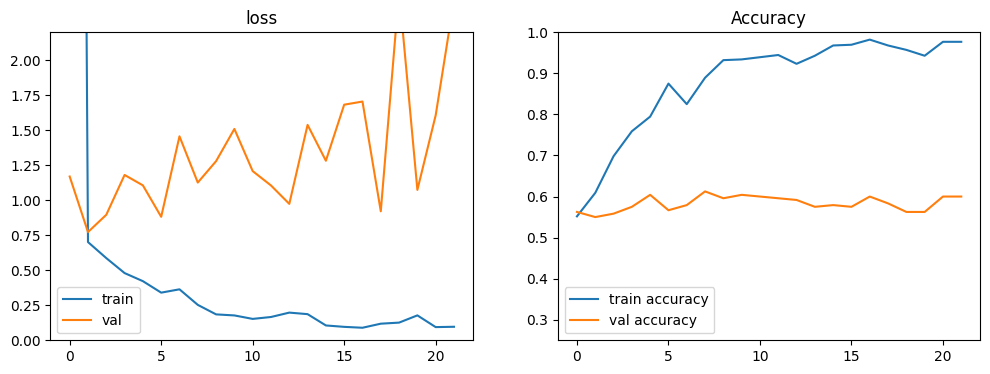

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

In [89]:
model, history = train(model, X_train, y_train, batch_size= 16,
                       patience= 20, validation_data= [X_val, y_val],
                       epochs= 100)
plot_history(history)